# DỰ ĐOÁN CỔ PHIẾU CỦA S&P500


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
pd.options.mode.chained_assignment = None

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from importlib import reload


import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tools.tools import add_constant

from math import sqrt

sns.set_style("darkgrid")
# Adds pandas custom converters for datetime, timestamp, and period
pd.plotting.register_matplotlib_converters()
%matplotlib inline


In [2]:
df = pd.read_csv('HistoricalData_1696582700396.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by = 'Date')
df.head()

,Date,Close_Last,Open,High,Low
2536,2013-10-07,1676.12,1687.15,1687.15,1674.70
2535,2013-10-08,1655.45,1676.22,1676.79,1655.03
2534,2013-10-09,1656.40,1656.99,1662.47,1646.47
2533,2013-10-10,1692.56,1660.88,1692.56,1660.88
2532,2013-10-11,1703.20,1691.09,1703.44,1688.52


In [3]:
df.duplicated().sum() #Check Duplicate value

0

<Axes: >

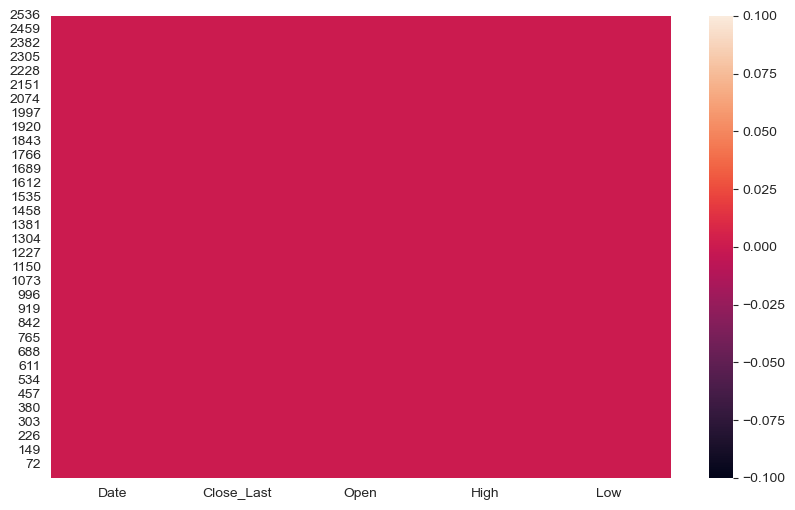

In [4]:
import seaborn as sns # Check missing value
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull())

## EDEA

In [5]:
df.describe()

,Date,Close_Last,Open,High,Low
count,2537,2537.000000,2537.000000,2537.00000,2537.000000
mean,2018-09-24 08:42:45.549861888,2934.405305,2918.393197,2934.16363,2901.333559
min,2013-10-07 00:00:00,1655.450000,0.000000,0.00000,0.000000
25%,2016-03-16 00:00:00,2099.600000,2099.340000,2106.01000,2088.860000
50%,2018-09-20 00:00:00,2746.560000,2747.610000,2761.52000,2728.810000
75%,2021-03-30 00:00:00,3817.660000,3815.110000,3843.09000,3789.490000
max,2023-10-05 00:00:00,4796.560000,4804.510000,4818.62000,4780.040000
std,NaN,890.858606,924.106080,930.50547,917.363716


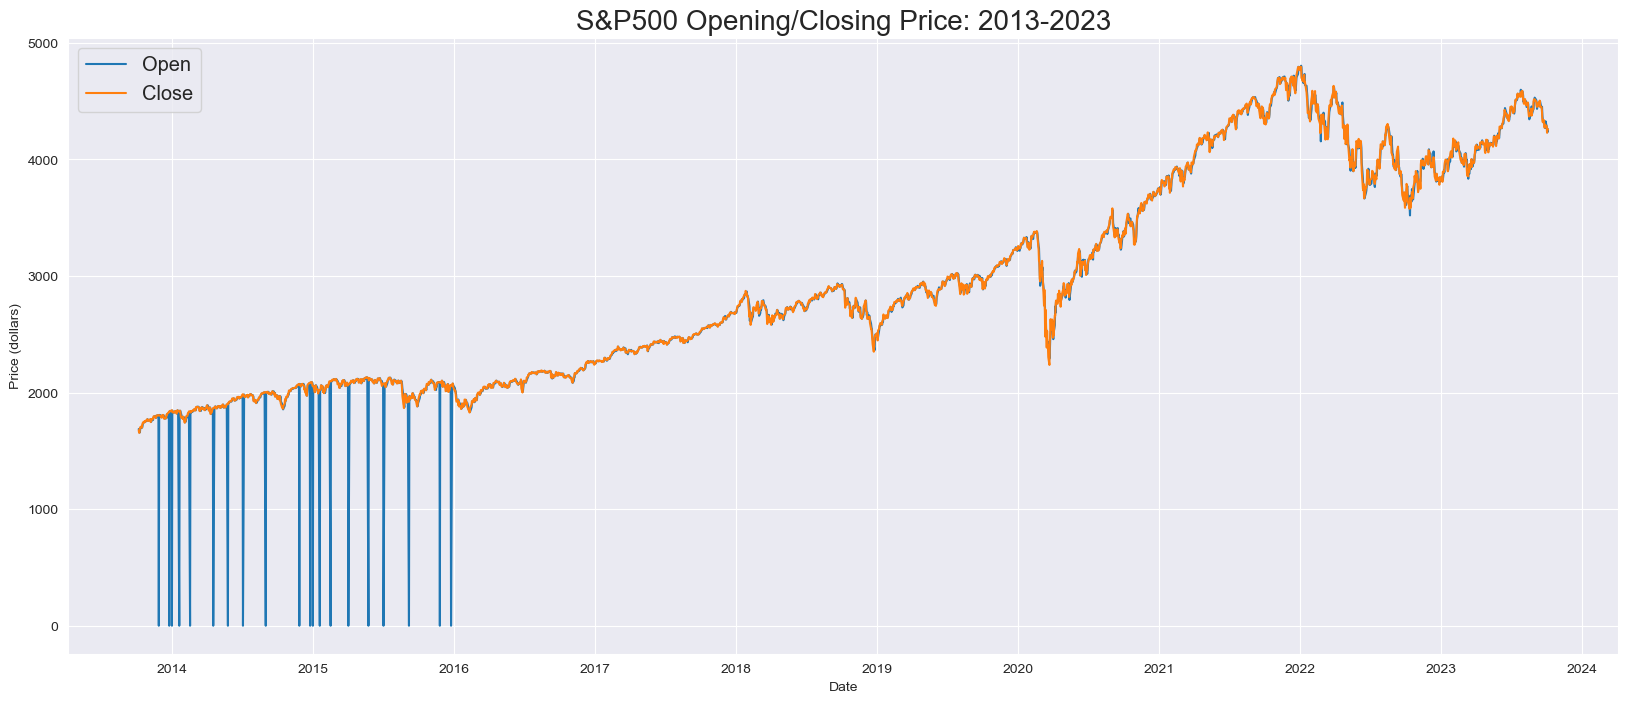

In [6]:
#Opening and closing price line plot for Amazon stock

f, ax = plt.subplots(figsize=(20,8))
sns.lineplot(data = df, y = 'Open', x = 'Date', ax = ax, label = 'Open')
sns.lineplot(data = df, y = 'Close_Last', x = 'Date', ax = ax, label = 'Close')

ax.set(xlabel='Date',
       ylabel='Price (dollars)')
ax.set_title('S&P500 Opening/Closing Price: 2013-2023', fontsize=20)
plt.legend(loc="upper left", fontsize='x-large')
plt.show()

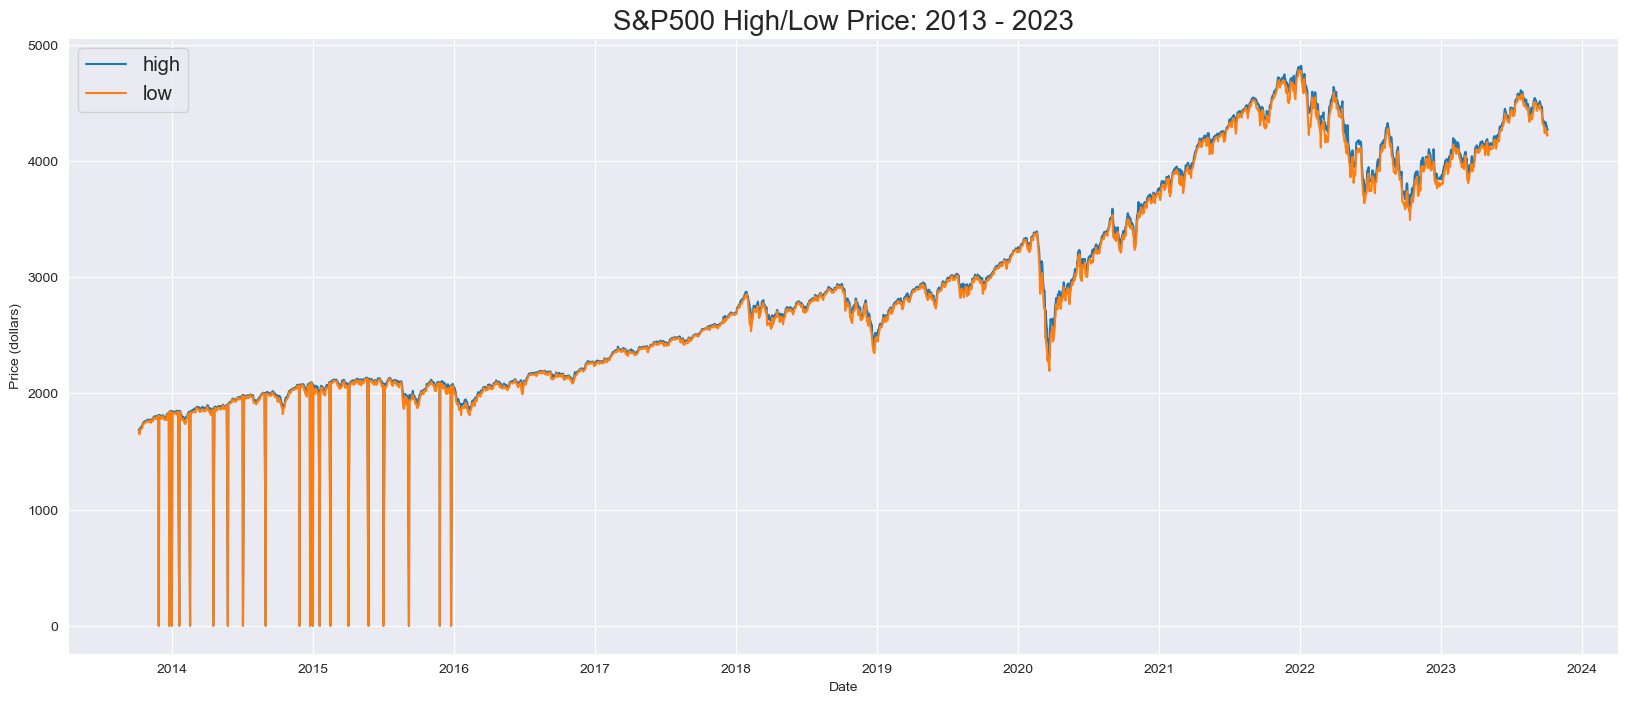

In [7]:
f, ax = plt.subplots(figsize=(20,8))
sns.lineplot(data=df, y='High', x='Date', label='high')
sns.lineplot(data=df, y='Low', x='Date', label='low')

ax.set(xlabel='Date',
       ylabel='Price (dollars)')
ax.set_title('S&P500 High/Low Price: 2013 - 2023', fontsize=20)
plt.legend(loc="upper left", fontsize='x-large')
plt.show()

## Model Building 

- ### Model Selection: Rolling OLS Regression

This model makes predictions time step by time step. After each prediction, the true observation is added to the model for the next prediction. This approach simulates a real-world scenario where new observations for the history are collected and used to update the model over time.

- ### Time Series Data Labeling

In [8]:
# Set the date column as the index
df.set_index('Date', inplace=True)

In [9]:
# Ex: Select Date range 
df.loc['2016-01-01':'2016-12-31']

,Close_Last,Open,High,Low
Date,,,,
2016-01-04,2012.66,2038.20,2038.20,1989.68
2016-01-05,2016.71,2013.78,2021.94,2004.17
2016-01-06,1990.26,2011.71,2011.71,1979.05
2016-01-07,1943.09,1985.32,1985.32,1938.83
2016-01-08,1922.03,1945.97,1960.40,1918.46
...,...,...,...,...
2016-12-23,2263.79,2260.25,2263.79,2258.84
2016-12-27,2268.88,2266.23,2273.82,2266.15
2016-12-28,2249.92,2270.23,2271.31,2249.11


In [10]:
# Ex: resample yearly frequency
df.resample('M').mean()  

,Close_Last,Open,High,Low
Date,,,,
2013-10-31,1726.451579,1723.370526,1731.553158,1717.008947
2013-11-30,1784.669048,1696.687143,1703.400952,1691.722857
2013-12-31,1808.936364,1724.317727,1730.141364,1718.685000
2014-01-31,1824.197826,1666.941304,1671.887826,1657.056957
2014-02-28,1818.114500,1722.371000,1732.969000,1716.101500
...,...,...,...,...
2023-06-30,4345.372857,4333.507619,4359.732857,4321.860000
2023-07-31,4508.075500,4505.434000,4523.726000,4492.960000
2023-08-31,4457.358696,4461.379565,4482.017391,4437.410870


## Train/Test set Split
Model is trained with data from the years 2016-2022(because some data is corrupted), predict on year 2023

In [11]:
# Split the data into training and test sets based on the dates
train = df.loc['2016-01-01':'2022-12-31']
test = df.loc['2023-01-01':]

## Model Training

In [12]:
# Add a constant (intercept term) to the predictors
train.loc[:, 'const'] = 1

# Define endog and exog
endog = train['Close_Last']
exog = train[['Open', 'High', 'Low','const']]

# Run the rolling window regression
model = RollingOLS(endog, exog, window=191)
rres = model.fit()

## Model Performing

- ### Predicted Values

Calculated as the dot product of the parameter values and the predictor values

In [13]:
# Generate predicted values
train['predicted_close'] = np.nan
for i in range(191, len(train)):
    train['predicted_close'].iloc[i] = np.dot(rres.params.iloc[i], train[['Open', 'High', 'Low','const']].iloc[i])

- ### Training Set Visualizations

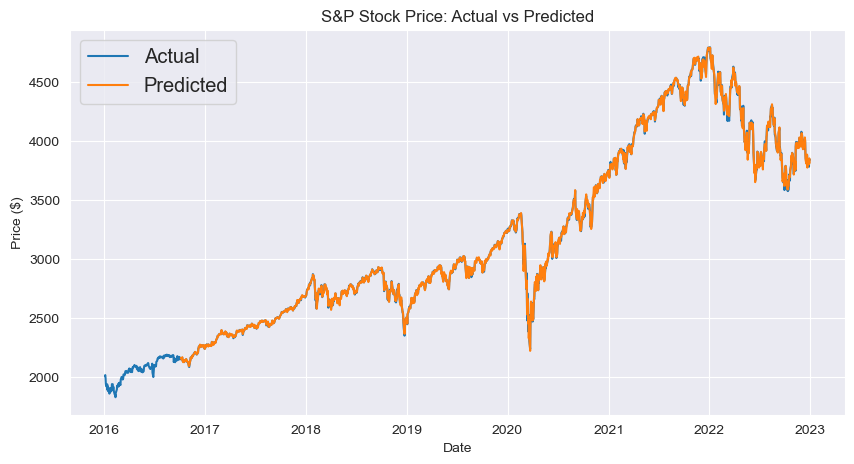

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(train.index, train['Close_Last'], label='Actual')
plt.plot(train.index, train['predicted_close'], label='Predicted')

plt.title('S&P Stock Price: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend(loc="upper left", fontsize='x-large')

In [15]:
#Calculate Root Mean Squared Error for the training set
train_2 = train.dropna()
rmse = np.sqrt(mean_squared_error(train_2['Close_Last'], train_2['predicted_close']))
print('Train RMSE:', rmse)

Train RMSE: 12.99599440123236


In this context, an RMSE of approximately 12.96 means that on average, the model's predictions for the closing price of S&P500's stock are about $12.96 away from the actual closing price.

In [16]:
train.describe()

,Close_Last,Open,High,Low,const,predicted_close
count,1762.000000,1762.000000,1762.000000,1762.000000,1762.0,1571.000000
mean,3113.382202,3113.137628,3130.474926,3094.052917,1.0,3240.963439
std,784.279188,784.409365,790.516159,777.800041,0.0,734.339529
min,1829.080000,1833.400000,1847.000000,1810.100000,1.0,2092.390471
25%,2488.245000,2491.925000,2503.480000,2473.970000,1.0,2672.019410
50%,2888.460000,2892.530000,2902.845000,2877.790000,1.0,2978.915919
75%,3820.942500,3817.755000,3847.295000,3791.755000,1.0,3900.595802
max,4796.560000,4804.510000,4818.620000,4780.040000,1.0,4793.364745


- ### Test Set Model

Generate predicted values for test set

In rolling regression, the parameters of the model are re-estimated at each time step of in the training data. This deals with the concept of out-of-sample forecasting with rolling window models.

The following code uses the most recent model to predict the first point in the test set, then take a time step, re-fit the model and make the next prediction.

In [17]:
# Define an empty array to store predicted values
predicted_close_test = np.empty(len(test))

# Add a constant (intercept term) to the test set
test['const'] = 1 

# For each day in the test set...
for i in range(len(test)):
    # Roll the window one day forward in the combined train and test data
    window = pd.concat([train, test[:i + 1]]).iloc[-191:]

    # Fit the model to the window
    endog = window['Close_Last']
    exog = window[['Open', 'High', 'Low', 'const']]  # Include 'const' in 'exog'
    model = sm.OLS(endog, exog)
    rres = model.fit()
        
    # Make a prediction for the next day
    predicted_close_test[i] = rres.predict(test[['Open', 'High', 'Low', 'const']].iloc[i])

# Add the predicted values to the test DataFrame
test['predicted_close'] = predicted_close_test

C:\Users\khois\AppData\Local\Temp\ipykernel_6412\2887013460.py:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  predicted_close_test[i] = rres.predict(test[['Open', 'High', 'Low', 'const']].iloc[i])
C:\Users\khois\AppData\Local\Temp\ipykernel_6412\2887013460.py:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  predicted_close_test[i] = rres.predict(test[['Open', 'High', 'Low', 'const']].iloc[i])
C:\Users\khois\AppData\Local\Temp\ipykernel_6412\2887013460.py:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  predicted_close_test[i] = rres.predict(test[['Open', 'High', 'Low', 'const']].iloc[i])
C:\Users\khois\AppData\Local\Temp\ipykernel_6412\2887013460.py:19: FutureWarning: Calling float on a si

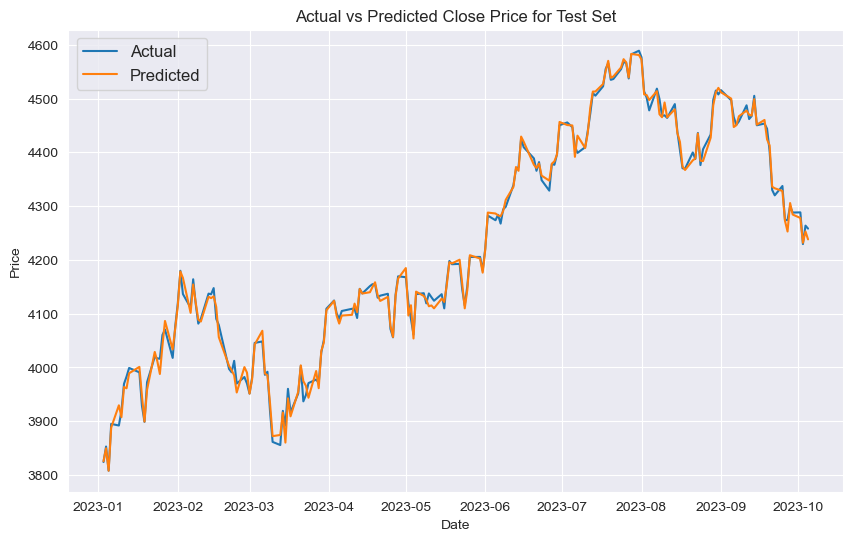

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Close_Last'], label='Actual')
plt.plot(test.index, test['predicted_close'], label='Predicted')
plt.title('Actual vs Predicted Close Price for Test Set')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc="upper left", fontsize='large')    
plt.show()

In [19]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Close_Last'], test['predicted_close']))
print('Test RMSE:', rmse)

Test RMSE: 12.026690027369252


In this context, an RMSE of approximately 12.02 means that on average, the model's predictions for the closing price of S&P500's stock are about $12.02 away from the actual closing price.

- ## Testing Specific Date

In [20]:
specific_dates = ['2023-01-03', '2023-09-26','2023-09-29']  # Replace with desired dates

for date in specific_dates:
    # Convert the date to a valid format
    formatted_date = pd.to_datetime(date, format='%Y-%m-%d', errors='coerce')

    # Check if the formatted date exists in the DataFrame's index
    if formatted_date in test.index:
        # Retrieve the prediction for the specific date
        prediction = test.loc[formatted_date, 'predicted_close']
        actual = test.loc[formatted_date, 'Close_Last']
        print(f'-PREDICTED Close value for {date}: {prediction:.2f}')
        print(f'   +ACTUAL Close value for {date}: {actual:.2f}')
        print('\n')
    else:
        print(f'Date {date} not found in the dataset.')

-PREDICTED Close value for 2023-01-03: 3825.63
   +ACTUAL Close value for 2023-01-03: 3824.14


-PREDICTED Close value for 2023-09-26: 4272.63
   +ACTUAL Close value for 2023-09-26: 4273.53


-PREDICTED Close value for 2023-09-29: 4284.36
   +ACTUAL Close value for 2023-09-29: 4288.05




In [21]:
coefficients = rres.params
print(coefficients)
print(test)

Open     -0.741599
High      0.763654
Low       0.965473
const    58.281215
dtype: float64
            Close_Last     Open     High      Low  const  predicted_close
Date                                                                     
2023-01-03     3824.14  3853.29  3878.46  3794.33      1      3825.626254
2023-01-04     3852.97  3840.36  3873.16  3815.77      1      3849.741856
2023-01-05     3808.10  3839.74  3839.74  3802.42      1      3808.013282
2023-01-06     3895.08  3823.37  3906.19  3809.56      1      3888.283946
2023-01-09     3892.09  3910.82  3950.57  3890.42      1      3929.644851
...                ...      ...      ...      ...    ...              ...
2023-09-29     4288.05  4328.18  4333.15  4274.86      1      4284.359786
2023-10-02     4288.39  4284.52  4300.58  4260.21      1      4277.978679
2023-10-03     4229.45  4269.75  4281.15  4216.45      1      4231.885741
2023-10-04     4263.75  4233.83  4268.50  4220.48      1      4252.854460
2023-10-05     4258.1

In [22]:
test.describe()

,Close_Last,Open,High,Low,const,predicted_close
count,191.000000,191.000000,191.000000,191.000000,191.0,191.000000
mean,4223.470995,4221.549267,4244.220942,4199.778796,1.0,4223.170063
std,207.428942,209.545824,205.081928,212.733372,0.0,207.847581
min,3808.100000,3823.370000,3839.740000,3794.330000,1.0,3808.013282
25%,4065.890000,4055.665000,4082.060000,4046.280000,1.0,4062.460775
50%,4169.480000,4164.100000,4186.920000,4142.540000,1.0,4176.347782
75%,4410.590000,4422.530000,4443.410000,4399.390000,1.0,4421.929623
max,4588.960000,4598.260000,4607.070000,4573.140000,1.0,4583.063570


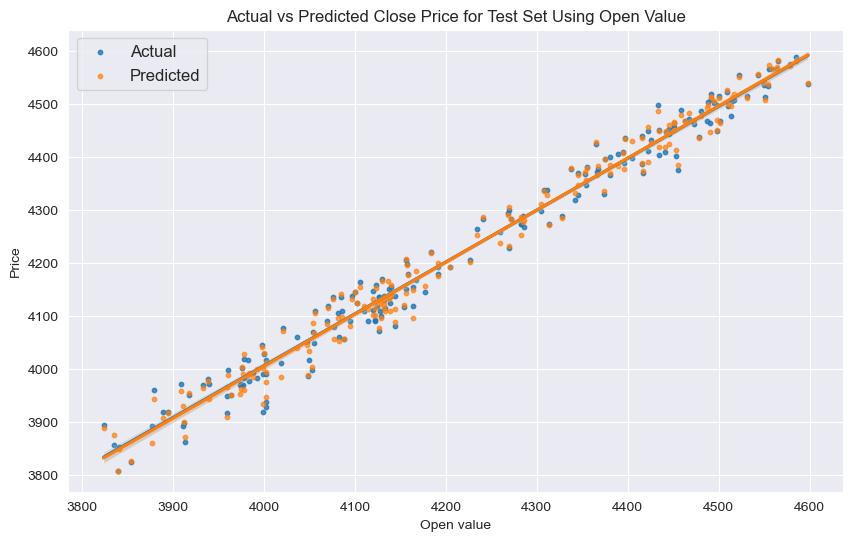

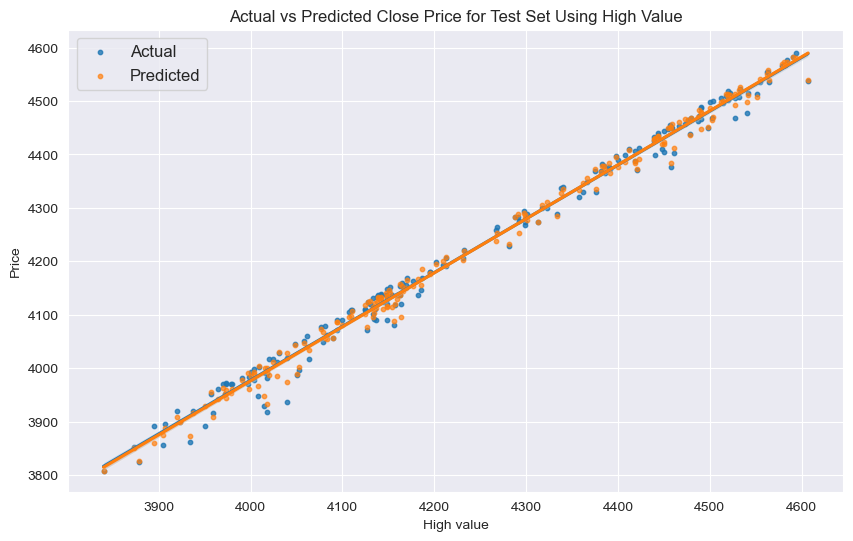

In [23]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
scatter_kws = {'s': 10, 'alpha': 0.7}
scatter = {'s': 10}

sns.regplot(x='Open',y='Close_Last',data=test,scatter_kws=scatter, label='Actual')
sns.regplot(x='Open', y='predicted_close',data=test,scatter_kws=scatter_kws, label='Predicted')
plt.title('Actual vs Predicted Close Price for Test Set Using Open Value')
plt.xlabel('Open value')
plt.ylabel('Price')
plt.legend(loc="upper left", fontsize='large')    
plt.show()

plt.figure(figsize=(10, 6))
sns.regplot(x='High',y='Close_Last',data=test,scatter_kws=scatter, label='Actual')
sns.regplot(x='High', y='predicted_close',data=test,scatter_kws=scatter_kws, label='Predicted')
plt.title('Actual vs Predicted Close Price for Test Set Using High Value')
plt.xlabel('High value')
plt.ylabel('Price')
plt.legend(loc="upper left", fontsize='large')    
plt.show()

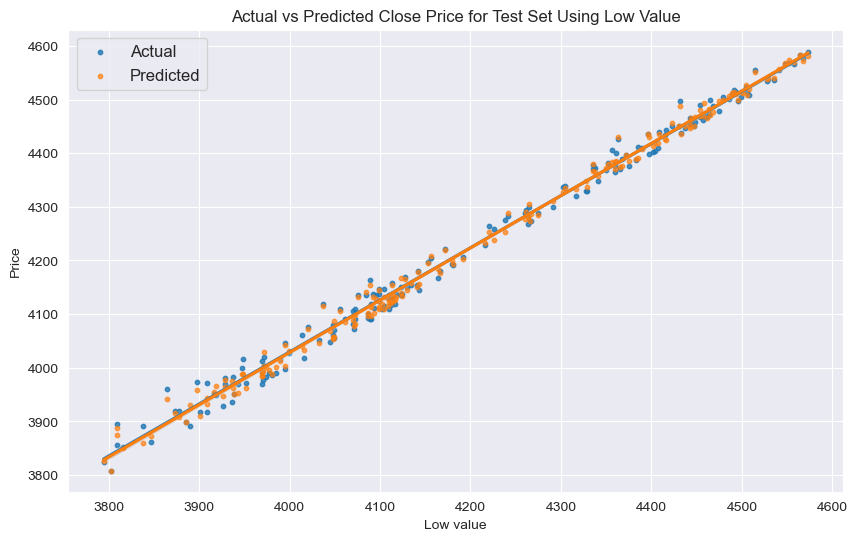

In [24]:
plt.figure(figsize=(10, 6))
sns.regplot(x='Low',y='Close_Last',data=test,scatter_kws=scatter, label='Actual')
sns.regplot(x='Low', y='predicted_close',data=test,scatter_kws=scatter_kws, label='Predicted')
plt.title('Actual vs Predicted Close Price for Test Set Using Low Value')
plt.xlabel('Low value')
plt.ylabel('Price')
plt.legend(loc="upper left", fontsize='large')    
plt.show()